In [20]:
import sys
import keras
import numpy
import cv2
import matplotlib
import skimage

print('Python Version: {}'.format(sys.version))
print('Keras Version: {}'.format(keras.__version__))
print('NumPy Version: {}'.format(numpy.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('Matplotlib Version: {}'.format(matplotlib.__version__))
print('Skimage Version: {}'.format(skimage.__version__))

Python Version: 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
Keras Version: 2.5.0
NumPy Version: 1.19.5
OpenCV: 4.5.2
Matplotlib Version: 3.4.2
Skimage Version: 0.18.1


In [21]:
from keras.models import Sequential
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import numpy as np
import math 
import os

%matplotlib inline

In [22]:
# define a function for PSNR (Peek signal to noise ratio)

def psnr(target, ref):
    
    # Considering that we use a RGB image
    target_data = target.astype('float')
    ref_data = ref.astype('float')
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    # Root mean squared error
    rmse = math.sqrt(np.mean(diff ** 2.))
    return 20*math.log10(255./rmse)

# Function for mean squared error

def mse(target,ref):
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1]) 
    
    return err

# function that combines all three image quality metrics

def compare_images (target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel = True))
    
    return scores

In [23]:
# create degraded or low-res images by introducing quality distortions by resizing 

def prepare_images(path, factor):
    
    #loop through the files in directory 
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        #find old and new image dimensions
        
        h, w, c = img.shape
        new_height = int(h/factor)
        new_width = int(w/factor)
        
        #resize the image - up and down
        
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR) #down
        img = cv2.resize(img, (w,h), interpolation = cv2.INTER_LINEAR) #up
        
        # Save the image
        
        print ('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file),img)
        
        
        

In [24]:
prepare_images('source/',2)

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp


In [31]:
# testing low resolution images

for file in os.listdir('images/'):
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    #Calculating the score
    
    scores = compare_images(target, ref)
    
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file,scores[0],scores[1],scores[2]))

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.629277587900277

baby_GT.bmp
PSNR: 34.37180640966199
MSE: 71.28874588012695
SSIM: 0.9356987872724932

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8347335416398209

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

flowers.bmp
PSNR: 27.454504805386147
MSE: 350.55093922651935
SSIM: 0.8697286286974628

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.8011121330733371

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.948005676

In [60]:
# building the srcnn model

def model():
    
    SRCNN = Sequential()
    
    SRCNN.add(Conv2D(filters = 128, kernel_size = (9,9), kernel_initializer = 'glorot_uniform',
                    activation = 'relu', padding = 'valid', use_bias = True, input_shape = (None, None,1)))
    SRCNN.add(Conv2D(filters = 64, kernel_size = (3,3), kernel_initializer = 'glorot_uniform',
                    activation = 'relu', padding = 'same', use_bias = True))
    SRCNN.add(Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = 'glorot_uniform',
                    activation = 'linear', padding = 'valid', use_bias = True))
    
    adam = Adam(learning_rate = 0.0003)
    
    SRCNN.compile(optimizer = "adam", loss = 'mean_squared_error', metrics = ['mean_squared_error'])
    
    return SRCNN

In [79]:
# deploying the SRCNN

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [111]:
# The prediction function

def predict(image_path):
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype = float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float)/255
    
    pre = srcnn.predict(Y, batch_size = 1)
    
    pre *=255
    pre[pre[:]>255] = 255
    pre[pre[:]<0] = 0
    pre = pre.astype(np.uint8)
    
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    return ref, degraded, output, scores


Degraded Image: 
PSNR: 27.368831974620207
MSE: 357.53488122802503
SSIM: 0.7527808342151686

Reconstructed Image using SRSCNN: 
PSNR: 28.674076399025246
MSE: 264.7244018523283
SSIM: 0.8292490233612808



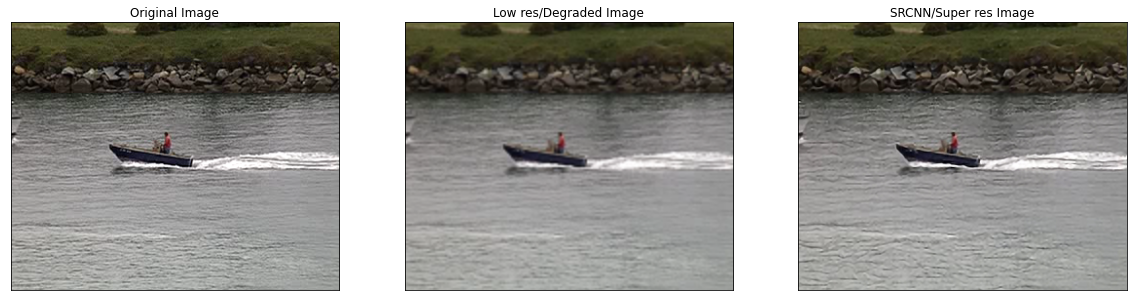

In [114]:
ref, degraded, output, scores = predict('images/coastguard.bmp')


print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0],scores[0][1],scores[0][2]))
print('Reconstructed Image using SRSCNN: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0],scores[1][1],scores[1][2]))

fig, axs = plt.subplots(1,3,figsize = (20,5))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Low res/Degraded Image')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN/Super res Image')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
    